# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090B Introduction to Data Science

## Section 2: FeedForward Neural Networks - Optimizers

**Harvard University**<br/>
**Spring 2026**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb<br/>

## Setup: Download Data

In [1]:
# Environment detection and setup
import os
import subprocess
import sys
import shutil

# Define the zip file URL and expected directories
assets_zip_url = "https://github.com/Harvard-CS1090/2026_CS1090B_public/raw/main/sec02/notebook_assets.zip"

assets_zip_name = "notebook_assets.zip"
expected_dirs = ["data", "fig"]

# Check if required directories already exist
all_dirs_exist = all(os.path.isdir(d) for d in expected_dirs)

if all_dirs_exist:
    print("Required directories already exist. Skipping download.")
else:
    print(f"Downloading {assets_zip_name} from GitHub...")
    
    # Use wget in Colab, or urllib for local
    try:
        if 'google.colab' in sys.modules:
            subprocess.run(['wget', '-q', assets_zip_url], check=True)
        else:
            import urllib.request
            urllib.request.urlretrieve(assets_zip_url, assets_zip_name)
        print(f"Downloaded {assets_zip_name}.")
        
        # Unzip the file
        import zipfile
        with zipfile.ZipFile(assets_zip_name, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Extracted {assets_zip_name}.")
        
        # Clean up the zip file
        os.remove(assets_zip_name)
        print(f"Removed {assets_zip_name}.")
        
        # Remove __MACOSX folder if it exists
        if os.path.isdir('__MACOSX'):
            shutil.rmtree('__MACOSX')
            print("Removed __MACOSX folder.")
        
    except Exception as e:
        print(f"Error during setup: {e}", file=sys.stderr)

print("Setup complete!")

Required directories already exist. Skipping download.
Setup complete!


In [2]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Reproducibility settings
SEED = 109
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Part 1: Regression with Neural Networks

Let's fit a difficult function where polynomial regression fails.

The [dielectric function](https://en.wikipedia.org/wiki/Permittivity) of many optical materials depends on the frequency and is given by the Lorentz model as:

$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma},$$

where $\omega$ is the frequency, $\omega_0$ is the resonance frequency of the bound electrons, and $\Gamma$ is the electron damping.

In many situations, we measure the real part of the dielectric function in the lab and then we fit these observations. Let's assume that we perform an experiment and the observations come from a Lorentz model.

In [4]:
df = pd.read_csv('data/lorentz_set.csv').sample(frac=1, random_state=SEED)  # shuffle DataFrame
print("Data shape: ",df.shape)
# Split train and test - very small dataset so we skip untouched test set. 
x_train, x_test, y_train, y_test = train_test_split(df.x, df.y, train_size=0.7, random_state=SEED)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
df.head(3)

Data shape:  (128, 2)
Training data shape: (89,)
Test data shape: (39,)


,x,y
23,0.362205,-0.143579
99,1.559055,1.697312
104,1.637795,1.593371


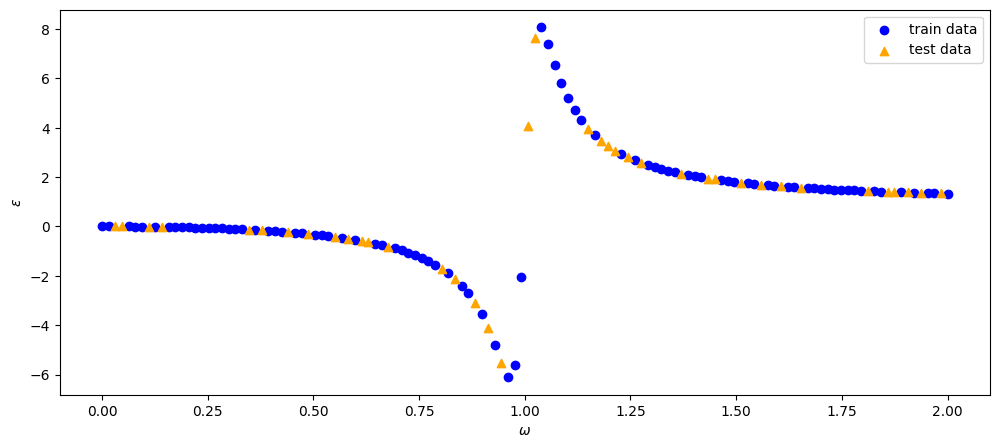

In [5]:
def plot_lorentz(df, test_idx, ax=None):
    """Plot the Lorentz data with train/test split."""
    if ax is None:
        ax = plt.gca()
    test_mask = df.index.isin(test_idx)
    ax.scatter(df.x[~test_mask], df.y[~test_mask], c='b', label='train data')
    ax.scatter(df.x[test_mask], df.y[test_mask], c='orange', marker='^', label='test data')
    ax.set_xlabel(r'$\omega$')
    ax.set_ylabel(r'$\epsilon$')
    ax.legend()

plt.figure(figsize=(12, 5))
plot_lorentz(df, x_test.index)

### Polynomial Regression Baseline

Let's first try fitting a high-degree polynomial to see why neural networks might be needed.

MSE on training set: 1.3231239526090004
MSE on testing set: 2.0708175633559938


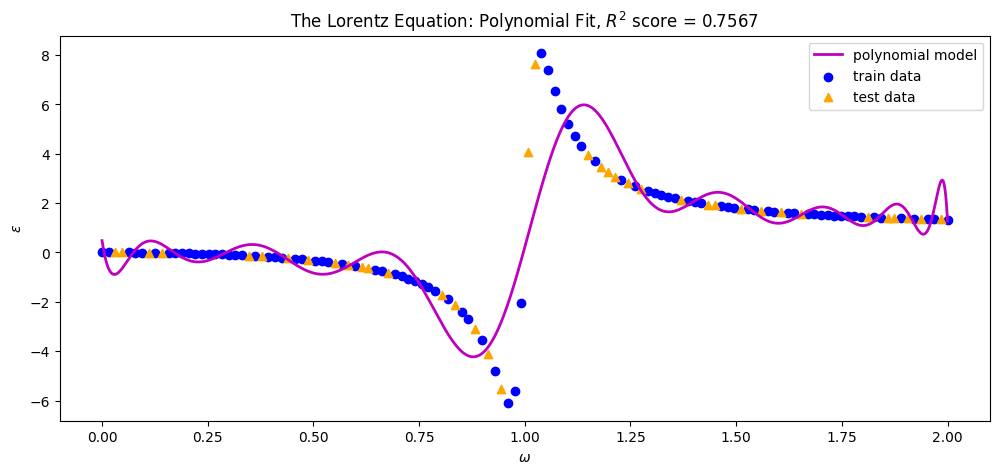

In [6]:
# Fit a 25-degree polynomial function to the data
polynomial_features = PolynomialFeatures(degree=25)
x_poly_train = polynomial_features.fit_transform(x_train.values.reshape(-1, 1))
x_poly_test = polynomial_features.transform(x_test.values.reshape(-1, 1))


model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
y_poly_train = model_poly.predict(x_poly_train)
y_poly_test = model_poly.predict(x_poly_test)

mse_train_poly = mean_squared_error(y_train, y_poly_train)
mse_test_poly = mean_squared_error(y_test, y_poly_test)
print('MSE on training set:', mse_train_poly)
print('MSE on testing set:', mse_test_poly)

x_lin = np.linspace(x_train.min(), x_train.max(), 1000)
x_lin_poly = polynomial_features.transform(x_lin.reshape(-1, 1))

y_poly_pred = model_poly.predict(x_lin_poly)

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.plot(x_lin, y_poly_pred, color='m', linewidth=2, label='polynomial model')
plot_lorentz(df, x_test.index, ax=ax)
ax.set_title(f"The Lorentz Equation: Polynomial Fit, $R^2$ score = {r2_score(y_train, y_poly_train):.4f}");

As expected, we get some wild behavior because we need a very high polynomial degree to begin to approximate this function.

Let's see if we can do better using a **feedforward neural network** with PyTorch.

### Building Neural Networks in PyTorch

In PyTorch, we define neural networks by creating a class that inherits from `nn.Module`. This gives us full control over the forward pass and allows for complex architectures.

The basic pattern is:
1. Define layers in `__init__`
2. Define the forward pass in `forward`

```python
class MyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
```

In [7]:
class LorentzNN(nn.Module):
    """Simple feedforward neural network for Lorentz function regression."""
    
    def __init__(self, hidden_sizes=[50, 50], activation='tanh'):
        super().__init__()
        
        # Build layers
        layers = []
        input_size = 1
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            input_size = hidden_size
        
        # Output layer (linear activation for regression)
        layers.append(nn.Linear(input_size, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create model and print summary
model = LorentzNN(hidden_sizes=[50, 50])
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

LorentzNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

Total parameters: 2,701


### PyTorch Training Loop

In PyTorch, we write an explicit training loop, which gives us full control over the training process.

The basic training loop:
1. **Forward pass**: Compute predictions
2. **Compute loss**: Compare predictions to targets
3. **Backward pass**: Compute gradients via `loss.backward()`
4. **Update weights**: Apply gradients via `optimizer.step()`

In [8]:
def train_model(model, X_train, y_train, X_val, y_val, 
                optimizer, criterion, epochs=100, verbose=True):
    """
    Train a PyTorch model and return training history.
    
    Args:
        model: PyTorch nn.Module
        X_train, y_train: Training data tensors
        X_val, y_val: Validation data tensors
        optimizer: PyTorch optimizer
        criterion: Loss function
        epochs: Number of training epochs
        verbose: Print progress every 50 epochs
    
    Returns:
        dict: Training history with 'loss' and 'val_loss' keys
    """
    history = {'loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        y_pred = model(X_train) # No mini-batching here
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
        
        history['loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")
    
    return history

In [9]:
# Helper function for plotting training history
def plot_history(history, title=None, ax=None):
    """Plot training and validation loss curves."""
    if ax is None:
        ax = plt.gca()
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE')
    best_loss = np.nanmin(history['val_loss'])
    best_epoch = np.nanargmin(history['val_loss'])
    ax.axvline(best_epoch, c='k', ls='--', label=f'best val loss = {best_loss:.2f}')
    ax.legend()
    if title:
        ax.set_title(title)

In [10]:
# Convert data to PyTorch tensors
X_train_t = torch.FloatTensor(x_train.values.reshape(-1, 1))
y_train_t = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_test_t = torch.FloatTensor(x_test.values.reshape(-1, 1))
y_test_t = torch.FloatTensor(y_test.values.reshape(-1, 1))

print(f"Training data shape: {X_train_t.shape}")
print(f"Test data shape: {X_test_t.shape}")

Training data shape: torch.Size([89, 1])
Test data shape: torch.Size([39, 1])


### Training the Neural Network

Now let's train our neural network on the Lorentz data and compare its fit to the polynomial baseline.

LorentzNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
Epoch 50/200 - Loss: 4.0144 - Val Loss: 3.8853
Epoch 100/200 - Loss: 0.6525 - Val Loss: 1.1202
Epoch 150/200 - Loss: 0.0487 - Val Loss: 0.4003
Epoch 200/200 - Loss: 0.0120 - Val Loss: 0.1582
Polynomial Test MSE: 2.07
Neural Net Test MSE:  0.16


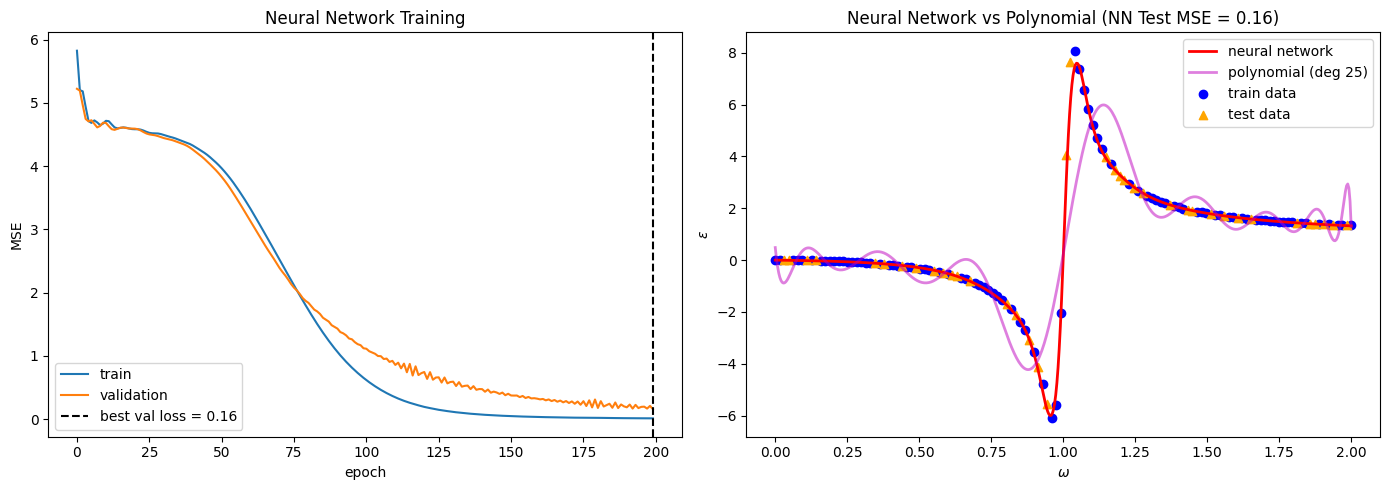

In [11]:
# Train the neural network
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

print(model)

history = train_model(model, X_train_t, y_train_t, X_test_t, y_test_t,
                      optimizer, criterion, epochs=200, verbose=True)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training history
plot_history(history, title='Neural Network Training', ax=axes[0])

# Predictions vs polynomial baseline
model.eval()
x_lin = np.linspace(df.x.min(), df.x.max(), 500).reshape(-1, 1)
x_lin_t = torch.FloatTensor(x_lin)
with torch.no_grad():
    y_nn_pred = model(x_lin_t).numpy()

# Recompute polynomial predictions on the same grid
x_lin_poly_new = polynomial_features.transform(x_lin)
y_poly_pred_new = model_poly.predict(x_lin_poly_new)

axes[1].plot(x_lin, y_nn_pred, color='r', linewidth=2, label='neural network')
axes[1].plot(x_lin, y_poly_pred_new, color='m', linewidth=2, alpha=0.5, label='polynomial (deg 25)')
plot_lorentz(df, x_test.index, ax=axes[1])

with torch.no_grad():
      mse_nn = mean_squared_error(y_test, model(X_test_t).numpy())
axes[1].set_title(f'Neural Network vs Polynomial (NN Test MSE = {mse_nn:.2f})')

fig.tight_layout()
print(f'Polynomial Test MSE: {mse_test_poly:.2f}')
print(f'Neural Net Test MSE:  {mse_nn:.2f}')

## Part 2: Weight Initializers

How we initialize the weights of a neural network can significantly affect training. PyTorch provides several initialization methods in `torch.nn.init`.

**Fan-in, Fan-out, and "gain"**

Many initializers are written in terms of:

- `fan_in`: number of input units to a layer
- `fan_out`: number of output units from a layer
- `gain`: a multiplier that depends on the activation function (e.g., ReLU vs tanh)

**Common Initializers**

The standard initializers you might expect are:
- `nn.init.normal_` — Normal distribution
- `nn.init.uniform_` — Uniform distribution
- `nn.init.ones_` — All ones
- `nn.init.zeros_` — All zeros

Some more sophisticated initializers include:

- **Xavier/Glorot normal** (`nn.init.xavier_normal_`)
  - `std = gain * sqrt(2 / (fan_in + fan_out))`
  - [Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a.html)

- **Xavier/Glorot uniform** (`nn.init.xavier_uniform_`)
  - samples from `U[-limit, limit]` where  
    `limit = gain * sqrt(6 / (fan_in + fan_out))`  

    *(Here, `U[a, b]` denotes a uniform distribution on `[a, b]`.)*

- **Kaiming/He normal** (`nn.init.kaiming_normal_`) *(commonly paired with ReLU / leaky ReLU)*
  - `std = gain / sqrt(fan_in)`
  - for ReLU, `gain = sqrt(2)` → `std = sqrt(2 / fan_in)`
  - [He et al., 2015](https://arxiv.org/abs/1502.01852)

- **Kaiming/He uniform** (`nn.init.kaiming_uniform_`) *(commonly paired with ReLU / leaky ReLU)*
  - samples from `U[-limit, limit]` where  
    `limit = sqrt(3) * std = sqrt(3) * gain / sqrt(fan_in)`
  - for ReLU, this becomes `limit = sqrt(6 / fan_in)`

**Note:** 

PyTorch default initialization for `nn.Linear`

PyTorch’s `nn.Linear` **does** use `kaiming_uniform_` internally, but **not with the ReLU gain**.

Specifically, PyTorch calls:

`nn.init.kaiming_uniform_(weight, a = sqrt(5))`

This choice makes the effective bound:

`weight ~ U[-1/sqrt(fan_in), +1/sqrt(fan_in)]`

So, **PyTorch uses Kaiming-uniform under the hood, but its default bound for `nn.Linear` is `± 1/sqrt(fan_in)`**, not `± sqrt(6/fan_in)` (which corresponds to ReLU gain).

In practice (not automatically in PyTorch), Xavier/Glorot is commonly used when a linear layer is followed by tanh or sigmoid, while Kaiming/He is commonly used when a linear layer is followed by ReLU or leaky ReLU.

In [12]:
def create_model_with_init(hidden_sizes, init_fn):
    """
    Create a model with a specific weight initialization.
    
    Args:
        hidden_sizes: List of hidden layer sizes
        init_fn: Initialization function to apply
    
    Returns:
        nn.Module: Initialized model (LorentzNN)
    """
    model = LorentzNN(hidden_sizes=hidden_sizes)
    
    for module in model.modules():
        if isinstance(module, nn.Linear):
            init_fn(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    return model

LorentzNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=5, bias=True)
    (5): Tanh()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)

Test MSE by Initializer:
  xavier_normal        1.46
  xavier_uniform       1.21
  kaiming_uniform      2.89
  normal               2.70


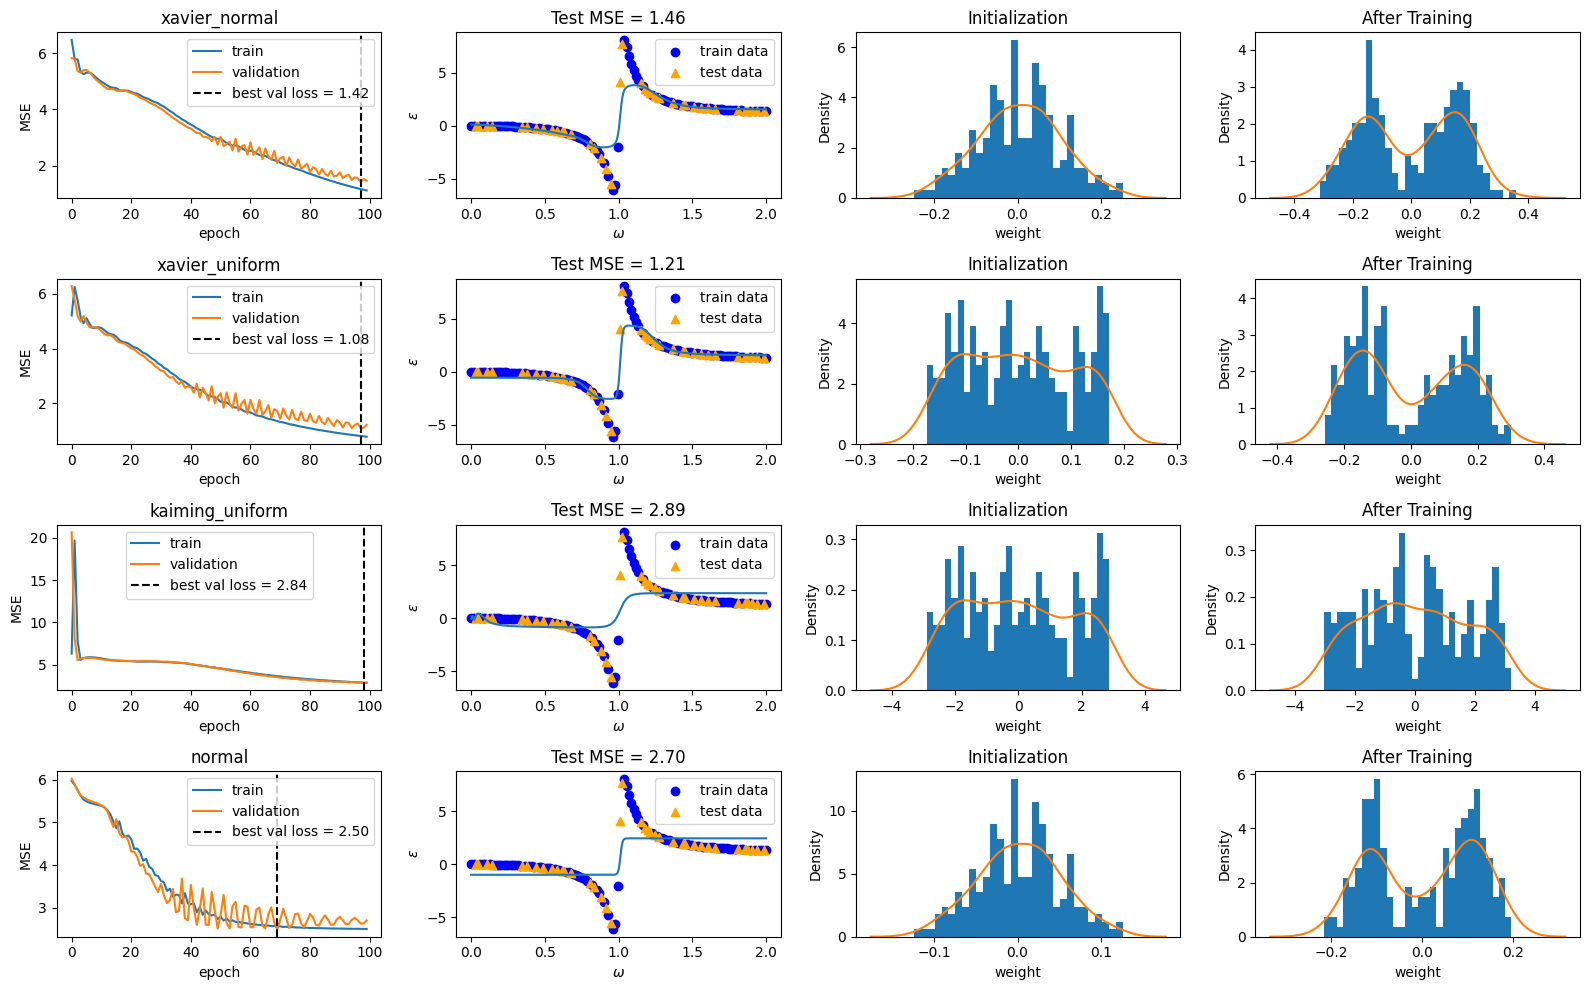

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(16, 10))

# Define initializers with their PyTorch equivalents
initializers = {
    'xavier_normal': lambda w: nn.init.xavier_normal_(w),
    'xavier_uniform': lambda w: nn.init.xavier_uniform_(w),
    'kaiming_uniform': lambda w: nn.init.kaiming_uniform_(w, nonlinearity='tanh'), ## gain adjusts for tanh  
    'normal': lambda w: nn.init.normal_(w, mean=0, std=0.05)
}

results = {}

for i, (init_name, init_fn) in enumerate(initializers.items()):
    # Build and initialize model
    torch.manual_seed(SEED)  # For reproducibility
    model = create_model_with_init([200, 50, 5], init_fn)

    if i == 0:
        print(model)
    # Get initial weights from first layer
    initial_weights = model.network[0].weight.data.numpy().flatten()
    axs[i, 2].hist(initial_weights, density=True, bins=30)
    sns.kdeplot(initial_weights, ax=axs[i, 2])
    axs[i, 2].set_xlabel('weight')
    axs[i, 2].set_title('Initialization')
    
    # Train
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    history = train_model(model, X_train_t, y_train_t, X_test_t, y_test_t,
                         optimizer, criterion, epochs=100, verbose=False)
    
    # Plot history
    plot_history(history, ax=axs[i, 0], title=init_name)
    
    # Plot predictions
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test_t).numpy()
    mse = mean_squared_error(y_test, y_hat)
    results[init_name] = mse
    x_lin = np.linspace(df.x.min(), df.x.max(), 500).reshape(-1, 1)
    x_lin_t = torch.FloatTensor(x_lin)
    with torch.no_grad():
        y_hat_lin = model(x_lin_t).numpy()
    axs[i, 1].plot(x_lin, y_hat_lin)
    plot_lorentz(df, test_idx=x_test.index, ax=axs[i, 1])
    axs[i, 1].set_title(f'Test MSE = {mse:.2f}')
    
    # Plot weights after training
    final_weights = model.network[0].weight.data.numpy().flatten()
    axs[i, 3].hist(final_weights, density=True, bins=30)
    sns.kdeplot(final_weights, ax=axs[i, 3])
    axs[i, 3].set_xlabel('weight')
    axs[i, 3].set_title('After Training')


fig.tight_layout()

print("\nTest MSE by Initializer:")
for name, mse in results.items():
    print(f"  {name:20s} {mse:.2f}")



The distributions of the weights in the first layer after fitting seem to become multi-modal, with peaks on either side of 0. Why might this be the case?

In any event, we can tell from the plots of the model predictions that we still have room for improvement. All these models seem to be **underfit**. More epochs could help, but let's first explore different options with our **optimizer**.

> **❓Question 1: Weight Initialization** 
>
> 1. Why do the weight distributions become bimodal after training?
> 2. What problems might occur if we initialized all weights to zero?
> 3. Why might Kaiming/He initialization be preferred for ReLU networks?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. In this case, during training model weights evolved from their initial distribution to bimodal distribution - because model is learning to make meaningful representations from the data - here trying to fit to lorentz function
> 2. This essentially would mean our model is learning from a single neuron rather than 200 neurons that we are using.
> 3. Kaiming/He initialization compensates for the fact that ReLU units output zero for half their inputs, which reduces the signal's variance by half at each layer. By initializing weights with double the variance of standard methods (like Xavier), Kaiming maintains consistent signal strength throughout deep networks and prevents the vanishing gradient problem.

</details>

## Part 3: Optimizers

Recall that backpropagation uses the chain rule to calculate the gradient of the loss with respect to the weights. But it is gradient descent that actually updates the model weights. How this update is performed is defined by the optimizer.

**From Lecture 2:** Gradient descent iteratively steps in the direction of the negative gradient to minimize the loss.

<img src="./fig/lec02_gradient_descent_summary.png" width="800">

---

### 1. Stochastic Gradient Descent (SGD)

[`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

```python
torch.optim.SGD(params, lr=0.01, momentum=0, dampening=0, 
                weight_decay=0, nesterov=False)
```

In mini-batch SGD, the gradients are averaged across all $m$ observations in a mini-batch:

$$g = \frac{1}{m} \sum_i \nabla_W L(f(x_i; W), y_i)$$

Then comes the update step where the weights are actually adjusted:

$$W^* = W - \eta g$$

Here, $\eta$ is our learning rate.

Because the gradient is calculated using a random sample (mini-batch), it is a 'noisy' approximation which can allow us to escape local minima.

In [14]:
# Save initial weights to reload for fair comparison
torch.manual_seed(SEED)
base_model = LorentzNN(hidden_sizes=[50, 50])  # Default init Kaiming uniform
initial_state = copy.deepcopy(base_model.state_dict())

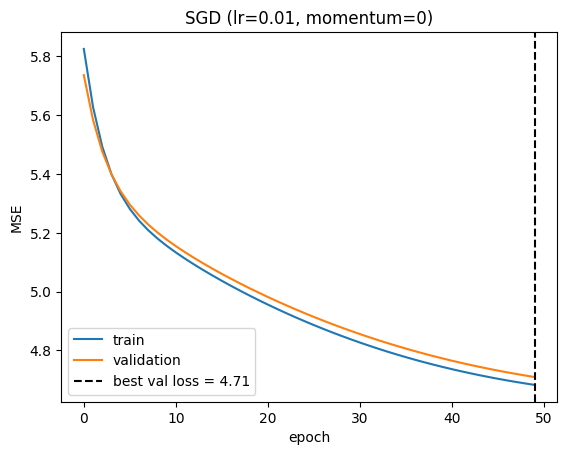

In [15]:
# Train with basic SGD
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

# Compile equivalent: create optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
criterion = nn.MSELoss()

history = train_model(model, X_train_t, y_train_t, X_test_t, y_test_t,
                     optimizer, criterion, epochs=50, verbose=False)

plot_history(history, title='SGD (lr=0.01, momentum=0)')

### Effect of Batch Size

When performing stochastic gradient descent, batch size is another hyperparameter. It is, after all, what makes the optimizer "stochastic"! The smaller the batches, the noisier the approximations of the gradient.

Let's see what happens with different batch sizes using PyTorch's DataLoader.

**From Lecture 2:** The mini-batch SGD algorithm — divide data into batches and update weights after each.

<img src="./fig/lec02_minibatch_sgd_algorithm.png" width="800">

In [16]:
def train_model_batched(model, X_train, y_train, X_val, y_val,
                        optimizer, criterion, batch_size, epochs=100, verbose=False):
    """
    Train with mini-batches using DataLoader.
    """
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    history = {'loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_X)
        
        epoch_loss /= len(X_train)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
        
        history['loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")
    
    return history

CPU times: user 2.44 s, sys: 82.6 ms, total: 2.53 s
Wall time: 2.48 s


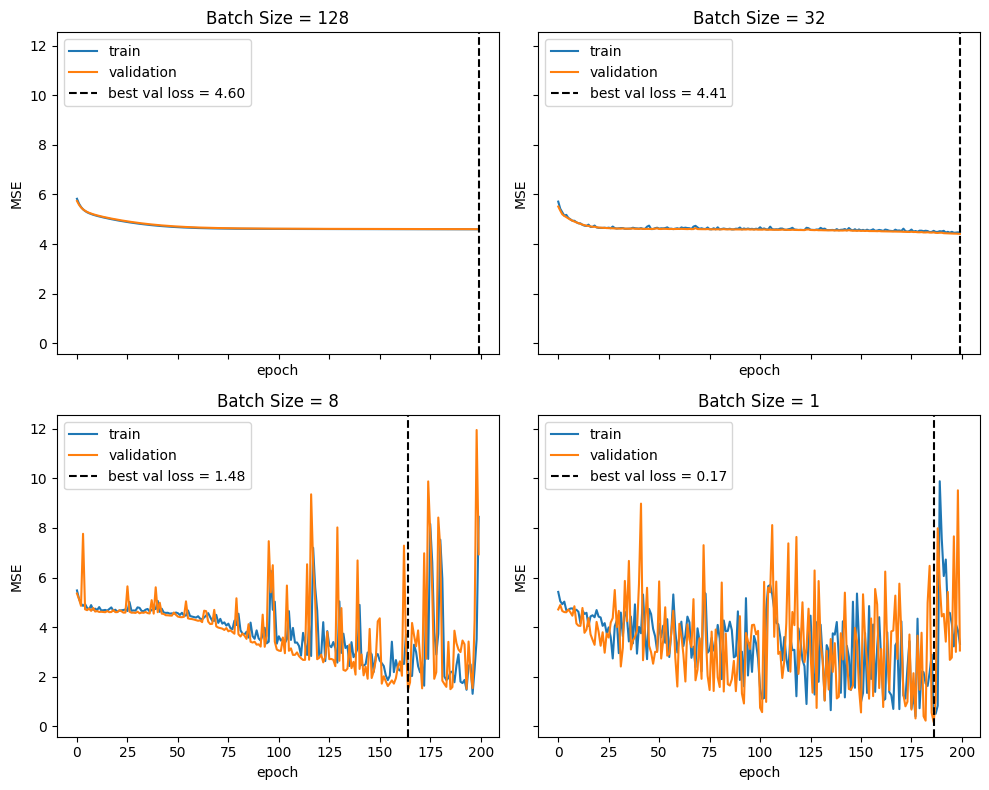

In [17]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.flatten()
batch_sizes = [128, 32, 8, 1]

for ax, batch_size in zip(axs, batch_sizes):
    torch.manual_seed(SEED)
    model = LorentzNN(hidden_sizes=[50, 50])
    model.load_state_dict(copy.deepcopy(initial_state))
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
    criterion = nn.MSELoss()
    
    history = train_model_batched(model, X_train_t, y_train_t, X_test_t, y_test_t,
                                  optimizer, criterion, batch_size=batch_size, epochs=200)
    
    plot_history(history, title=f'Batch Size = {batch_size}', ax=ax)

plt.tight_layout()

**Summary**
- batch size = 1: **vanilla SGD**. Just one example at a time to take a single step.
- batch size = m: **mini-batch SGD**. Uses only the points in the mini-batch to calculate the loss function.
- batch size = all data: **batch gradient descent**.

### Effect of Learning Rate

Vanilla SGD has a fixed learning rate. Let's see how adjusting it as a hyperparameter affects the performance of our model.

**From Lecture 2:** The effect of learning rate on gradient descent convergence.

<img src="./fig/lec02_learning_rate_effects.png" width="800">

CPU times: user 575 ms, sys: 8.72 ms, total: 584 ms
Wall time: 587 ms


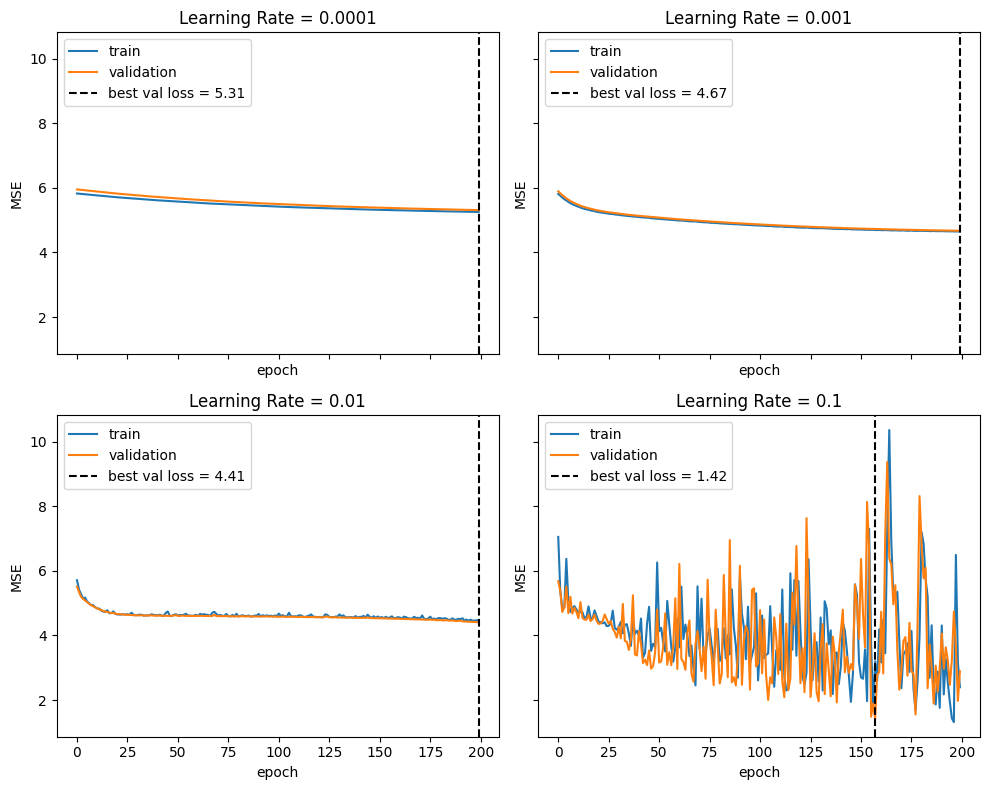

In [18]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.flatten()
lrs = [1e-4, 1e-3, 1e-2, 0.1]

for ax, lr in zip(axs, lrs):
    torch.manual_seed(SEED)
    model = LorentzNN(hidden_sizes=[50, 50])
    model.load_state_dict(copy.deepcopy(initial_state))
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0)
    criterion = nn.MSELoss()
    
    history = train_model_batched(model, X_train_t, y_train_t, X_test_t, y_test_t,
                                  optimizer, criterion, batch_size=32, epochs=200)
    
    plot_history(history, title=f'Learning Rate = {lr}', ax=ax)

plt.tight_layout()

Clearly some of these learning rates are too low, causing the loss to decrease very slowly as the weight updates are being scaled down considerably. The learning rate of 0.1 reaches a much lower loss, but it starts to oscillate wildly, apparently bouncing in and out of minima because of the high learning rate.

### Learning Rate Scheduling

You can use a learning rate schedule to modulate how the learning rate of your optimizer changes over time.

PyTorch provides schedulers in [`torch.optim.lr_scheduler`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

Common schedulers:
- `StepLR`: Decay by gamma every step_size epochs
- `ExponentialLR`: Decay by gamma every epoch
- `ReduceLROnPlateau`: Reduce when metric stops improving
- `CosineAnnealingLR`: Cosine annealing schedule

In [19]:
from torch.optim.lr_scheduler import ExponentialLR

# Exercise: Try an exponentially-decaying learning rate.
# Use an initial learning rate of 0.1 and a decay factor (gamma) of 0.99
# your code here
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = ExponentialLR(optimizer, gamma=0.99)  # Decays lr by 0.99 each epoch
criterion = nn.MSELoss()

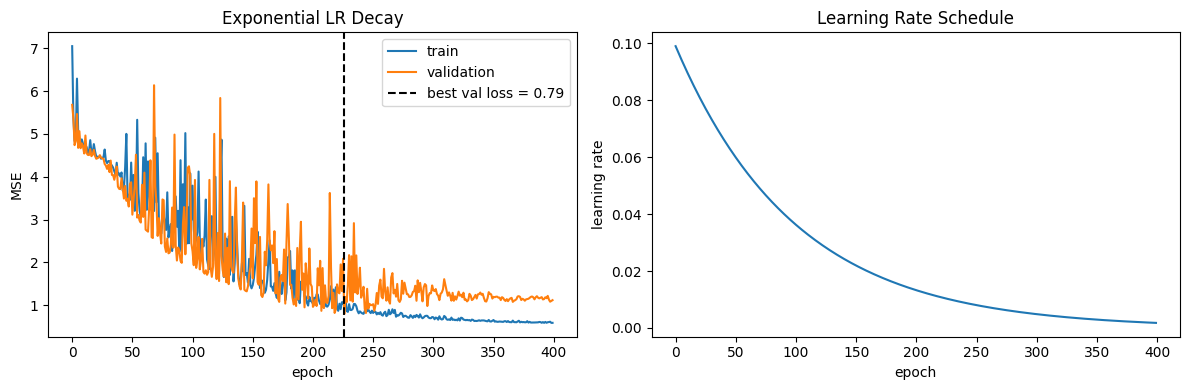

In [20]:
# Training with LR scheduler
def train_with_scheduler(model, X_train, y_train, X_val, y_val,
                         optimizer, scheduler, criterion, batch_size, epochs):
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    history = {'loss': [], 'val_loss': [], 'lr': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_X)
        
        epoch_loss /= len(X_train)
        
        # Step the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
        
        history['loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(current_lr)
    
    return history

history = train_with_scheduler(model, X_train_t, y_train_t, X_test_t, y_test_t,
                               optimizer, scheduler, criterion, batch_size=32, epochs=400)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_history(history, title='Exponential LR Decay', ax=axs[0])
axs[1].plot(history['lr'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('learning rate')
axs[1].set_title('Learning Rate Schedule')
plt.tight_layout()

---

### 2. Adagrad

[`torch.optim.Adagrad`](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html)

Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the updates.

<img src="./fig/adagrad_update_rule.png" width="600">

A weight's learning rate is inversely proportional to the root of its accumulated squared component of the gradient:

$$r^*_i = r_i + g^2_i$$


$$W^*_i = W_i - \frac{\epsilon}{\delta + \sqrt{r^*_i}}g_i$$


[Duchi et al., 2011](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

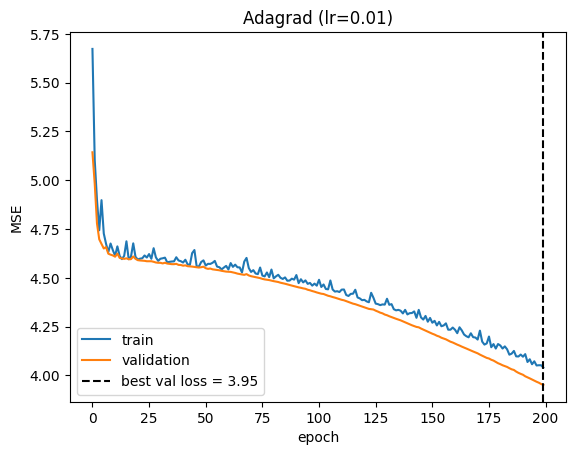

In [21]:
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

# Exercise: Create Adagrad optimizer with learning rate 0.01
# your code here
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

history = train_model_batched(model, X_train_t, y_train_t, X_test_t, y_test_t,
                              optimizer, criterion, batch_size=32, epochs=200)

plot_history(history, title='Adagrad (lr=0.01)')

As you can see, there is a problem with this approach. The accumulated gradients can quickly shrink the learning rates to the point where the network is no longer learning anything.

But we have a fix for this!

---

### 3. RMSprop

[`torch.optim.RMSprop`](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html)

RMSprop maintains a moving (discounted) average of the square of gradients and divides the current gradient by the root of this average (RMS = root mean square).

$$r^*_i = \rho r_i + (1-\rho)g^2_i$$

$$W^*_i = W_i - \frac{\epsilon}{\delta + \sqrt{r^*_i}}g_i$$  

[Hinton, 2012](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

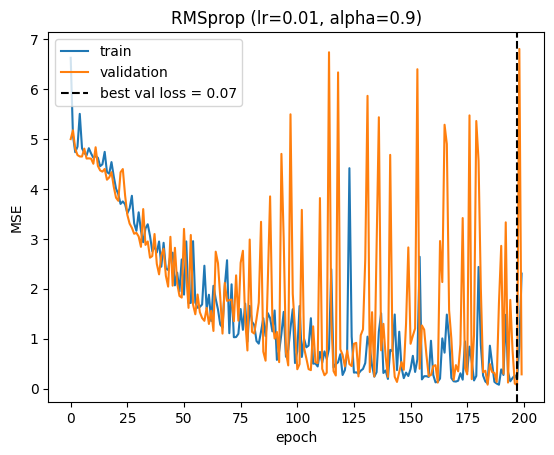

In [22]:
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.9, momentum=0)
criterion = nn.MSELoss()

history = train_model_batched(model, X_train_t, y_train_t, X_test_t, y_test_t,
                              optimizer, criterion, batch_size=32, epochs=200)

plot_history(history, title='RMSprop (lr=0.01, alpha=0.9)')

This works well, but can we also have it use information about the general trajectory or "trend"?

---

### 4. SGD with Momentum

If we incorporate information about **past updates**, might that help us converge faster?

**Momentum** helps us move along with the general trajectory we've taken so far, with oscillations cancelling themselves out.

<img src="./fig/momentum_visualization.png" width="600">

Updates are made using a weighted average of the current gradient $g$ and the average "trend" seen so far $v$:

$$v = \alpha v + (1-\alpha)g$$

$$W^* = W - \eta v$$

CPU times: user 719 ms, sys: 12.3 ms, total: 731 ms
Wall time: 739 ms


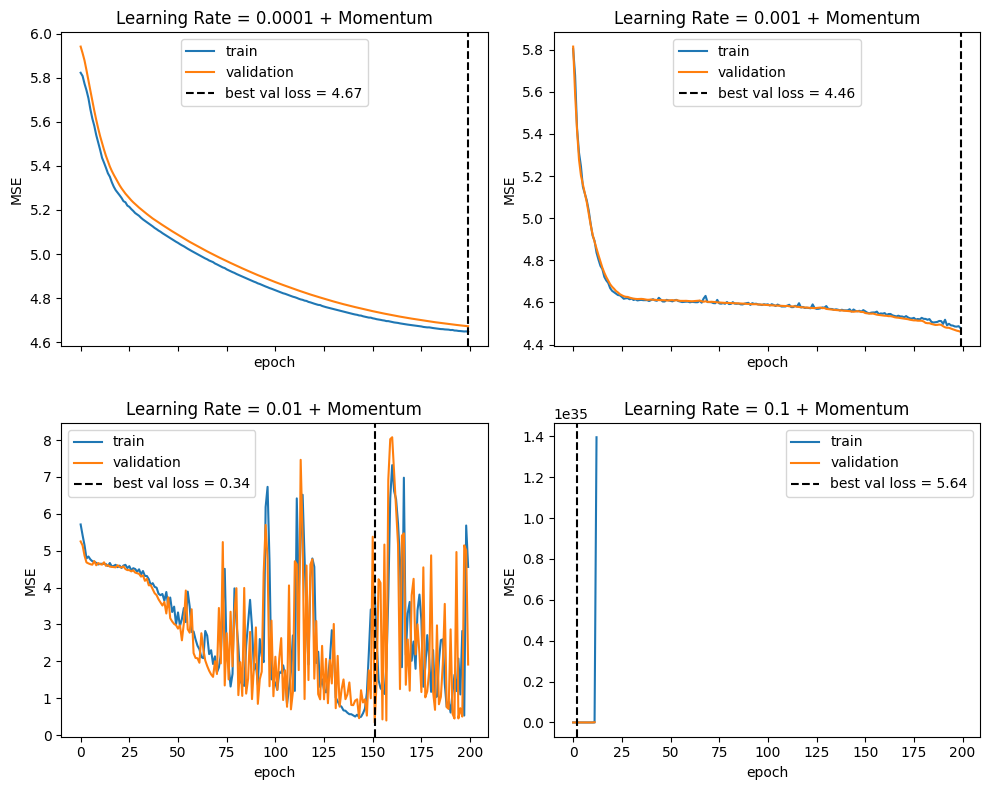

In [23]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()
lrs = [1e-4, 1e-3, 1e-2, 0.1]

for ax, lr in zip(axs, lrs):
    torch.manual_seed(SEED)
    model = LorentzNN(hidden_sizes=[50, 50])
    model.load_state_dict(copy.deepcopy(initial_state))
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=False)
    criterion = nn.MSELoss()
    
    history = train_model_batched(model, X_train_t, y_train_t, X_test_t, y_test_t,
                                  optimizer, criterion, batch_size=32, epochs=200)
    
    plot_history(history, title=f'Learning Rate = {lr} + Momentum', ax=ax)

plt.tight_layout()

What happened in the 4th example above? Let's train again with those parameters and look at the detailed output.

In [24]:
# Inspect strange behavior in 4th plot above
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.MSELoss()

# Manual training to see each epoch
dataset = TensorDataset(X_train_t, y_train_t)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(15):
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(batch_X)
    
    epoch_loss /= len(X_train_t)
    
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_t).item()
    
    print(f"Epoch {epoch+1}/15 - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")

Epoch 1/15 - loss: 6.8230 - val_loss: 7.0988
Epoch 2/15 - loss: 8.5355 - val_loss: 10.0463
Epoch 3/15 - loss: 9.7869 - val_loss: 5.6435
Epoch 4/15 - loss: 7.6262 - val_loss: 7.2819
Epoch 5/15 - loss: 7.3525 - val_loss: 16.6950
Epoch 6/15 - loss: 29.5020 - val_loss: 83.6878
Epoch 7/15 - loss: 1346.7488 - val_loss: 119072.6641
Epoch 8/15 - loss: 105150833.2360 - val_loss: 21610213376.0000
Epoch 9/15 - loss: 16838800425144.0898 - val_loss: 3939418360512512.0000
Epoch 10/15 - loss: 5075440691037699072.0000 - val_loss: 1188975634373714903040.0000
Epoch 11/15 - loss: 1531838975702108634873856.0000 - val_loss: 358849345512819219488571392.0000
Epoch 12/15 - loss: 462329943187501346065263624192.0000 - val_loss: 108305691212337016687113187360768.0000
Epoch 13/15 - loss: 139537336912504141542512446886903808.0000 - val_loss: inf
Epoch 14/15 - loss: inf - val_loss: inf
Epoch 15/15 - loss: nan - val_loss: nan


It looks like the combination of high learning rate and momentum caused a numerical overflow, likely from hitting very 'steep' parts of the loss surface. It is bad news once you get a `nan` in your computations.

In [25]:
# Check if weights became NaN
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"{name}: Contains NaN values!")
    else:
        print(f"{name}: OK (min={param.min().item():.4f}, max={param.max().item():.4f})")

network.0.weight: Contains NaN values!
network.0.bias: Contains NaN values!
network.2.weight: Contains NaN values!
network.2.bias: Contains NaN values!
network.4.weight: Contains NaN values!
network.4.bias: Contains NaN values!


### Gradient Clipping

We can take steps to prevent outcomes like this. In PyTorch, we use `torch.nn.utils.clip_grad_norm_` or `clip_grad_value_` to prevent giant gradients (and thus giant weight updates) from causing problems.

In [26]:
def train_with_grad_clip(model, X_train, y_train, X_val, y_val,
                         optimizer, criterion, batch_size, epochs, max_norm=1.0):
    """
    Train with gradient clipping to prevent exploding gradients.
    """
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    history = {'loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            
            optimizer.step()
            epoch_loss += loss.item() * len(batch_X)
        
        epoch_loss /= len(X_train)
        
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
        
        history['loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
    
    return history

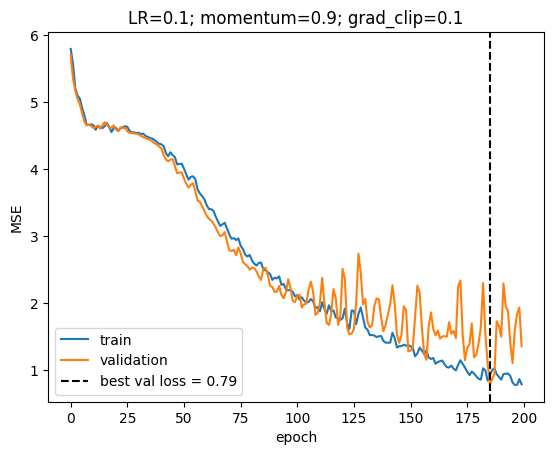

In [27]:
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

# Exercise: Create SGD optimizer with lr=0.1, momentum=0.9
# and use gradient clipping with max_norm=0.1
# your code here
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.MSELoss()

history = train_with_grad_clip(model, X_train_t, y_train_t, X_test_t, y_test_t,
                               optimizer, criterion, batch_size=32, epochs=200, max_norm=0.1)

plot_history(history, title='LR=0.1; momentum=0.9; grad_clip=0.1')

---

### 5. Adam (Adaptive Moment Estimation)

[`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments (basically, momentum + RMSprop).

```python
torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
```

[Kingma et al., 2014](http://arxiv.org/abs/1412.6980)

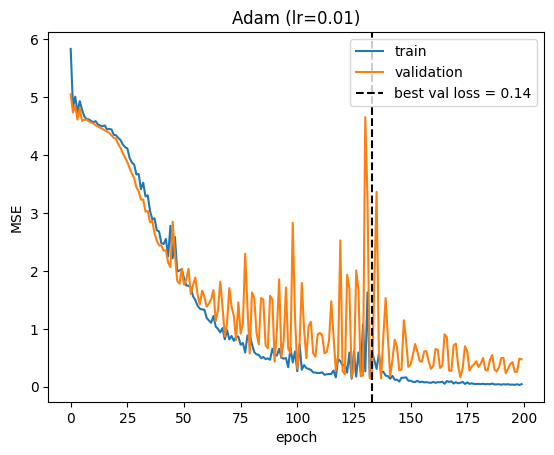

In [28]:
torch.manual_seed(SEED)
model = LorentzNN(hidden_sizes=[50, 50])
model.load_state_dict(copy.deepcopy(initial_state))

# Exercise: Create Adam optimizer with learning rate 0.01
# your code here
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
criterion = nn.MSELoss()

history = train_model_batched(model, X_train_t, y_train_t, X_test_t, y_test_t,
                              optimizer, criterion, batch_size=32, epochs=200)

plot_history(history, title='Adam (lr=0.01)')

Very nice. Perhaps the lowest MSE we've seen so far. How does the fit look?

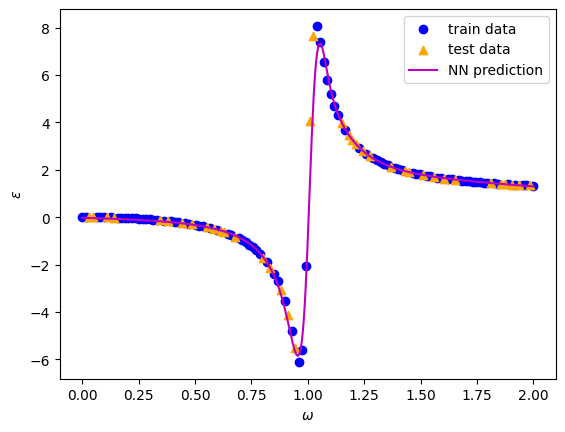

In [29]:
plot_lorentz(df, test_idx=x_test.index)
ax = plt.gca()

model.eval()
x_lin = np.linspace(df.x.min(), df.x.max(), 500).reshape(-1, 1)
x_lin_t = torch.FloatTensor(x_lin)
with torch.no_grad():
    y_hat = model(x_lin_t).numpy()
ax.plot(x_lin, y_hat, c='m', label='NN prediction')
ax.legend();

Much better than our original polynomial model!

---

**Other Optimizer Implementations Available in PyTorch:**
- [`Adadelta`](https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html) - Improvement on Adagrad
- [`Adamax`](https://pytorch.org/docs/stable/generated/torch.optim.Adamax.html) - Variant of Adam based on infinity norm
- [`NAdam`](https://pytorch.org/docs/stable/generated/torch.optim.NAdam.html) - Adam with Nesterov momentum
- [`AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) - Adam with decoupled weight decay

> **❓ Question 2: Optimizers**
>
> 1. What is the key difference between SGD and Adam?
> 2. Why might gradient clipping be important when using high learning rates with momentum?
> 3. In what scenarios might you prefer SGD over Adam?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The key difference is that Adam uses adaptive learning rates for each parameter, while SGD uses a fixed learning rate for all parameters. 
> 2. Because momentum accumulates updates, high learning rates can cause very large parameter jumps (unstable training / exploding updates / NaNs). Clipping caps the gradient (or its norm) so one bad step doesn’t blow up training.
> 3. When you care about generalization and can use a good learning-rate schedule, SGD often matches or beats Adam on final test performance common in vision/CNNs like ResNets. Also: SGD is simpler and uses less optimizer memory than Adam.

</details>

## Part 4: Overfitting

So far we've been looking at an oversimplified dataset where all the datapoints are right on top of the true generating function. But the real world is noisy!

In [30]:
df2 = pd.read_csv('data/lorentz_noise_set2.csv')
df2 = df2.sample(frac=1, random_state=SEED)  # shuffle DataFrame
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    df2.x, df2.y, train_size=0.7, random_state=SEED
)

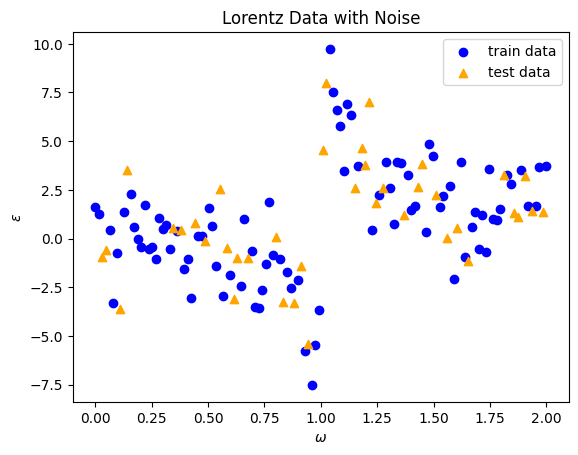

In [31]:
plot_lorentz(df2, x_test2.index)
plt.title('Lorentz Data with Noise');

In [32]:
# Convert noisy data to tensors
X_train2_t = torch.FloatTensor(x_train2.values.reshape(-1, 1))
y_train2_t = torch.FloatTensor(y_train2.values.reshape(-1, 1))
X_test2_t = torch.FloatTensor(x_test2.values.reshape(-1, 1))
y_test2_t = torch.FloatTensor(y_test2.values.reshape(-1, 1))

How does our previously best performing model fare on this more realistic dataset?

CPU times: user 2.24 s, sys: 849 ms, total: 3.09 s
Wall time: 2.42 s


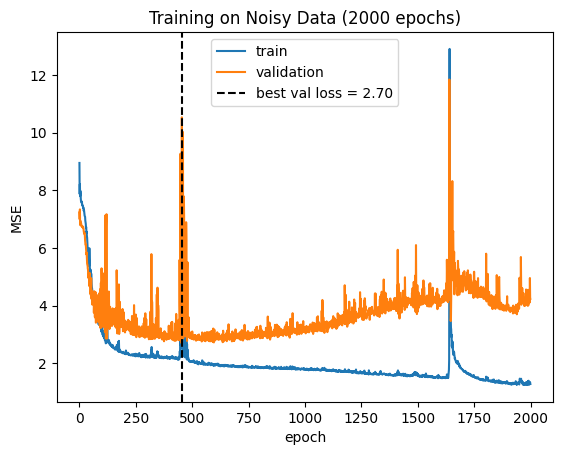

In [33]:
%%time
torch.manual_seed(SEED)
model_overfit = LorentzNN(hidden_sizes=[50, 50])

optimizer = optim.Adam(model_overfit.parameters(), lr=0.01, betas=(0.9, 0.999))
criterion = nn.MSELoss()

history = train_model_batched(model_overfit, X_train2_t, y_train2_t, X_test2_t, y_test2_t,
                              optimizer, criterion, batch_size=32, epochs=2000, verbose=False)

plot_history(history, title='Training on Noisy Data (2000 epochs)')

There are clear signs of overfitting as the validation error starts to diverge from the train error. Any "improvement" seen with respect to the training data after a certain point no longer generalizes. And after a while, we actually start to see the validation loss increasing.

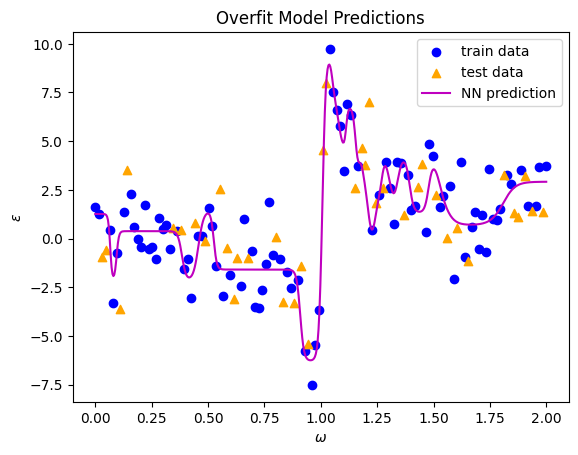

In [34]:
# Plot the overfit predictions
plot_lorentz(df2, test_idx=x_test2.index)
ax = plt.gca()

model_overfit.eval()
x_lin = np.linspace(df2.x.min(), df2.x.max(), 500).reshape(-1, 1)
x_lin_t = torch.FloatTensor(x_lin)
with torch.no_grad():
    y_hat = model_overfit(x_lin_t).numpy()
ax.plot(x_lin, y_hat, c='m', label='NN prediction')
ax.legend()
ax.set_title('Overfit Model Predictions');

And here we can see the model predictions jump around as it tries to fit the sparse and noisy points in the training data.

Luckily we have several tools at our disposal for addressing overfitting in neural networks... to be continued!

> **❓ Question 3: Overfitting**
>
> 1. At approximately which epoch does overfitting begin (where val_loss starts increasing)?
> 2. What techniques might help prevent overfitting? (We'll cover these in future labs)
> 3. Why does the model create "wiggly" predictions when overfit?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Based on the plot titled "Training on Noisy Data (2000 epochs)" , it seems after approx. 480-500 epochs overfitting begins. 

> 2. Regularization, Data augmentation, reducing model complexity / capacity should help.

> 3. Instead of learning the smooth underlying Lorentz function, the model learns to fit the random noise in individual training points.

</details>

## Part 5: Image Classification with Feedforward Neural Networks

In this section we will be working with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

<img src="./fig/fashion_mnist_examples.jpg" width="400px" />

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from one of 10 classes.

We will be using a very small fraction of the dataset.

In [35]:
import torchvision
import torchvision.transforms as transforms

# Download Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

In [36]:
# Fashion-MNIST class labels
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label2idx = {label: idx for idx, label in enumerate(labels)}
print(label2idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


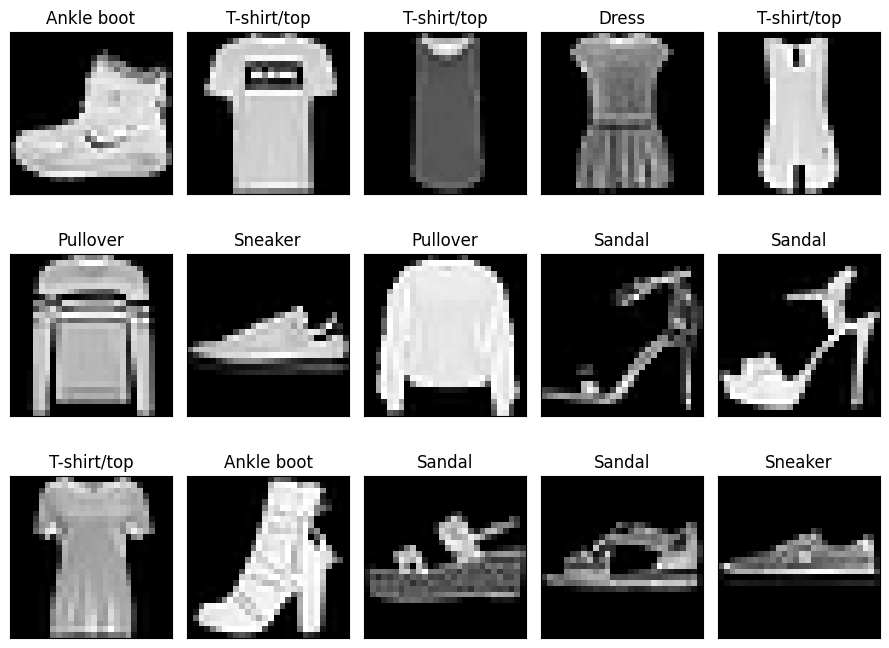

In [37]:
# View some examples
fig, axs = plt.subplots(3, 5, figsize=(9, 7))
for i, ax in enumerate(axs.ravel()):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(labels[label])
plt.tight_layout()

In [38]:
# Dataset size
print(f"Full training set: {len(train_dataset)} images")
print(f"Full test set: {len(test_dataset)} images")

Full training set: 60000 images
Full test set: 10000 images


Because we'd like a model we can train multiple times as we experiment during the section, we will use a subset of the data.

In [39]:
from torch.utils.data import Subset

# Use a subset of the data for faster training
np.random.seed(SEED)
train_indices = np.random.choice(len(train_dataset), size=1200, replace=False)
test_indices = np.random.choice(len(test_dataset), size=1000, replace=False)

# Split into train and validation
train_idx, val_idx = train_indices[:960], train_indices[960:]

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)
test_subset = Subset(test_dataset, test_indices)

print(f"Training subset: {len(train_subset)} images")
print(f"Validation subset: {len(val_subset)} images")
print(f"Test subset: {len(test_subset)} images")

Training subset: 960 images
Validation subset: 240 images
Test subset: 1000 images


In [40]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

### Building a Classifier Neural Network

Let's build our first attempt at a clothing classifier and try to overfit.

Note that PyTorch has a `nn.Flatten()` layer! We can use this to automatically turn input images into 1D arrays.
(We'll see how to handle 2D input with CNNs in future lectures and sections)

In [41]:
class FashionClassifier(nn.Module):
    """
    Feedforward neural network for Fashion-MNIST classification.
    """
    
    def __init__(self, input_dim=28*28, hidden_dims=[256, 128], num_classes=10):
        super().__init__()
        
        layers = [nn.Flatten()]  # Flatten 28x28 images to 784-dim vectors
        
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        # Output layer (no softmax - CrossEntropyLoss handles it)
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [42]:
# Exercise: Create your classifier model
# Experiment with different hidden_dims like [256, 128], [512, 256, 128], etc.


# your code here
# BEGIN SOLUTION
model_classifier = FashionClassifier(hidden_dims=[256, 128])
print(model_classifier)
print(f"\nTotal parameters: {sum(p.numel() for p in model_classifier.parameters()):,}")

# END SOLUTION

FashionClassifier(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 235,146


### Training the Classifier

In [43]:
def train_classifier(model, train_loader, val_loader, optimizer, criterion, 
                     epochs=30, patience=5):
    """
    Train a classifier with early stopping.
    
    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        optimizer: PyTorch optimizer
        criterion: Loss function
        epochs: Maximum number of epochs
        patience: Early stopping patience
    
    Returns:
        dict: Training history
    """
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_weights = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels_batch.size(0)
            train_correct += (predicted == labels_batch).sum().item()
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels_batch in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Restore best weights
    if best_weights is not None:
        model.load_state_dict(best_weights)
    
    return history

In [44]:
%%time
# Train the classifier
torch.manual_seed(SEED)
model_classifier = FashionClassifier(hidden_dims=[256, 128])

optimizer = optim.Adam(model_classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = train_classifier(model_classifier, train_loader, val_loader,
                           optimizer, criterion, epochs=30, patience=5)

Epoch 1/30 - loss: 1.5274 - acc: 0.4958 - val_loss: 1.2049 - val_acc: 0.5500
Epoch 2/30 - loss: 0.8820 - acc: 0.6510 - val_loss: 0.8349 - val_acc: 0.6958
Epoch 3/30 - loss: 0.7342 - acc: 0.7281 - val_loss: 0.8186 - val_acc: 0.7333
Epoch 4/30 - loss: 0.6354 - acc: 0.7656 - val_loss: 0.6986 - val_acc: 0.7417
Epoch 5/30 - loss: 0.5511 - acc: 0.8042 - val_loss: 0.7410 - val_acc: 0.7583
Epoch 6/30 - loss: 0.5179 - acc: 0.8115 - val_loss: 0.6665 - val_acc: 0.7792
Epoch 7/30 - loss: 0.5051 - acc: 0.8115 - val_loss: 0.7159 - val_acc: 0.7542
Epoch 8/30 - loss: 0.4405 - acc: 0.8458 - val_loss: 0.7647 - val_acc: 0.7542
Epoch 9/30 - loss: 0.4123 - acc: 0.8521 - val_loss: 0.6632 - val_acc: 0.7708
Epoch 10/30 - loss: 0.3986 - acc: 0.8677 - val_loss: 0.6872 - val_acc: 0.7625
Epoch 11/30 - loss: 0.3568 - acc: 0.8750 - val_loss: 0.6620 - val_acc: 0.7667
Epoch 12/30 - loss: 0.3004 - acc: 0.8948 - val_loss: 0.7038 - val_acc: 0.7542
Epoch 13/30 - loss: 0.3123 - acc: 0.8896 - val_loss: 0.6638 - val_acc: 0.

### Evaluate the Model

In [45]:
def evaluate_classifier(model, data_loader):
    """Evaluate model on a DataLoader."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels_batch in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()
    
    return total_loss / total, correct / total

train_loss, train_acc = evaluate_classifier(model_classifier, train_loader)
val_loss, val_acc = evaluate_classifier(model_classifier, val_loader)
test_loss, test_acc = evaluate_classifier(model_classifier, test_loader)

print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test  - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Train - Loss: 0.1768, Accuracy: 0.9437
Val   - Loss: 0.6327, Accuracy: 0.7917
Test  - Loss: 0.5237, Accuracy: 0.8300


### Plot the Training History

Best Val Accuracy: 0.79 (epoch 16)
Final Val Accuracy (last epoch): 0.78


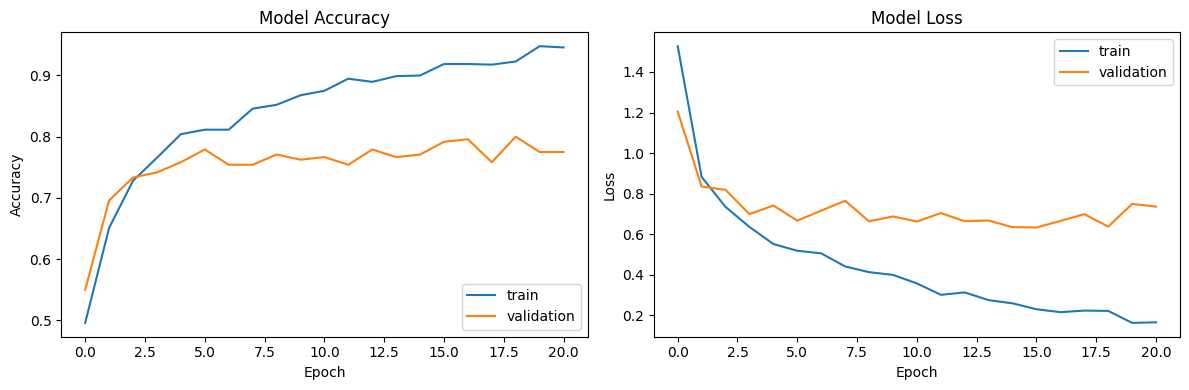

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

best_epoch = np.argmin(history['val_loss'])
print(f"Best Val Accuracy: {history['val_accuracy'][best_epoch]:.2f} (epoch {best_epoch + 1})")
print(f"Final Val Accuracy (last epoch): {history['val_accuracy'][-1]:.2f}")

# Accuracy plot
axs[0].plot(history['accuracy'], label='train')
axs[0].plot(history['val_accuracy'], label='validation')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Loss plot
axs[1].plot(history['loss'], label='train')
axs[1].plot(history['val_loss'], label='validation')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

plt.tight_layout()

In the next section we'll look at regularization techniques and data augmentation which will allow us to improve generalization!

> **❓ Question 4: Classification**
>
> 1. Why do we use `nn.CrossEntropyLoss()` instead of `nn.MSELoss()` for classification?
> 2. Why don't we need a softmax layer at the end of our classifier?
> 3. What accuracy would you expect from random guessing on this 10-class problem?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. MSE assumes continuous outputs, Classification outputs are categorical — we care about getting the right class, not minimizing squared distance to one-hot vectors.

> 2. nn.CrossEntropyLoss() expects raw logits (unnormalized scores), not probabilities. Internally, it applies log-softmax before computing the loss. Better numerical stability.

> 3. 10% for this 10 class problem.

</details>

---

## 🏋️ TEAM ACTIVITY: Optimizer Comparison

Compare the performance of different optimizers on the Fashion-MNIST classification task.

---

**Train with SGD**

Train the `FashionClassifier` using SGD with a few different learning rate and momentum combinations. Store each history so we can compare later.

**Hint:** Remember to re-initialize the model and set `torch.manual_seed(SEED)` before each run for a fair comparison.

In [47]:
# your code here
# BEGIN SOLUTION
sgd_configs = [
    {'lr': 0.01, 'momentum': 0.0},
    {'lr': 0.01, 'momentum': 0.9},
    {'lr': 0.1,  'momentum': 0.9},
]

sgd_results = {}

for cfg in sgd_configs:
    label = f"SGD(lr={cfg['lr']}, mom={cfg['momentum']})"
    print(f"\n{'='*60}")
    print(f"Training: {label}")
    print(f"{'='*60}")
    
    torch.manual_seed(SEED)
    model = FashionClassifier(hidden_dims=[256, 128])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    criterion = nn.CrossEntropyLoss()
    
    history = train_classifier(model, train_loader, val_loader,
                               optimizer, criterion, epochs=30, patience=5)
    
    _, val_acc = evaluate_classifier(model, val_loader)
    sgd_results[label] = {'history': history, 'val_acc': val_acc}
    print(f"Best Val Accuracy: {val_acc:.4f}")
# END SOLUTION


Training: SGD(lr=0.01, mom=0.0)
Epoch 1/30 - loss: 2.2801 - acc: 0.1573 - val_loss: 2.2640 - val_acc: 0.2042
Epoch 2/30 - loss: 2.2442 - acc: 0.2302 - val_loss: 2.2317 - val_acc: 0.2750
Epoch 3/30 - loss: 2.2030 - acc: 0.3229 - val_loss: 2.1948 - val_acc: 0.3667
Epoch 4/30 - loss: 2.1531 - acc: 0.4469 - val_loss: 2.1490 - val_acc: 0.3875
Epoch 5/30 - loss: 2.0906 - acc: 0.4573 - val_loss: 2.0897 - val_acc: 0.4042
Epoch 6/30 - loss: 2.0113 - acc: 0.4708 - val_loss: 2.0123 - val_acc: 0.4375
Epoch 7/30 - loss: 1.9148 - acc: 0.4667 - val_loss: 1.9183 - val_acc: 0.4542
Epoch 8/30 - loss: 1.8004 - acc: 0.5021 - val_loss: 1.8139 - val_acc: 0.5042
Epoch 9/30 - loss: 1.6792 - acc: 0.5813 - val_loss: 1.7019 - val_acc: 0.5250
Epoch 10/30 - loss: 1.5596 - acc: 0.5854 - val_loss: 1.5880 - val_acc: 0.5708
Epoch 11/30 - loss: 1.4519 - acc: 0.6219 - val_loss: 1.4894 - val_acc: 0.5750
Epoch 12/30 - loss: 1.3558 - acc: 0.6323 - val_loss: 1.4028 - val_acc: 0.6000
Epoch 13/30 - loss: 1.2754 - acc: 0.6385

**Train with RMSprop**

Train with `RMSprop`. You can experiment with the learning rate.

In [48]:
# your code here
# BEGIN SOLUTION
print(f"\n{'='*60}")
print(f"Training: RMSprop(lr=0.001)")
print(f"{'='*60}")

torch.manual_seed(SEED)
model = FashionClassifier(hidden_dims=[256, 128])
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

rmsprop_history = train_classifier(model, train_loader, val_loader,
                                   optimizer, criterion, epochs=30, patience=5)

_, rmsprop_val_acc = evaluate_classifier(model, val_loader)
print(f"Best Val Accuracy: {rmsprop_val_acc:.4f}")
# END SOLUTION


Training: RMSprop(lr=0.001)
Epoch 1/30 - loss: 1.3567 - acc: 0.4979 - val_loss: 0.9713 - val_acc: 0.6458
Epoch 2/30 - loss: 0.8107 - acc: 0.6813 - val_loss: 0.8301 - val_acc: 0.6667
Epoch 3/30 - loss: 0.6880 - acc: 0.7396 - val_loss: 0.7525 - val_acc: 0.7542
Epoch 4/30 - loss: 0.6189 - acc: 0.7750 - val_loss: 0.7076 - val_acc: 0.7625
Epoch 5/30 - loss: 0.5759 - acc: 0.7896 - val_loss: 0.6966 - val_acc: 0.7375
Epoch 6/30 - loss: 0.5061 - acc: 0.8229 - val_loss: 0.6784 - val_acc: 0.7667
Epoch 7/30 - loss: 0.4960 - acc: 0.8250 - val_loss: 0.6714 - val_acc: 0.7667
Epoch 8/30 - loss: 0.4398 - acc: 0.8365 - val_loss: 0.6861 - val_acc: 0.7625
Epoch 9/30 - loss: 0.4122 - acc: 0.8510 - val_loss: 0.6733 - val_acc: 0.7833
Epoch 10/30 - loss: 0.3920 - acc: 0.8490 - val_loss: 0.6874 - val_acc: 0.7583
Epoch 11/30 - loss: 0.3823 - acc: 0.8677 - val_loss: 0.6768 - val_acc: 0.7708
Epoch 12/30 - loss: 0.3366 - acc: 0.8823 - val_loss: 0.6781 - val_acc: 0.7667

Early stopping at epoch 12
Best Val Accurac

**Train with Adam**

Train with `Adam` using a few different learning rates. Adam was already used earlier in Part 5 — how do other learning rates compare?

In [49]:
# your code here
# BEGIN SOLUTION
adam_lrs = [0.0001, 0.001, 0.01]
adam_results = {}

for lr in adam_lrs:
    label = f"Adam(lr={lr})"
    print(f"\n{'='*60}")
    print(f"Training: {label}")
    print(f"{'='*60}")
    
    torch.manual_seed(SEED)
    model = FashionClassifier(hidden_dims=[256, 128])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    history = train_classifier(model, train_loader, val_loader,
                               optimizer, criterion, epochs=30, patience=5)
    
    _, val_acc = evaluate_classifier(model, val_loader)
    adam_results[label] = {'history': history, 'val_acc': val_acc}
    print(f"Best Val Accuracy: {val_acc:.4f}")
# END SOLUTION


Training: Adam(lr=0.0001)
Epoch 1/30 - loss: 2.2151 - acc: 0.2750 - val_loss: 2.1344 - val_acc: 0.4875
Epoch 2/30 - loss: 1.9931 - acc: 0.5740 - val_loss: 1.8862 - val_acc: 0.6208
Epoch 3/30 - loss: 1.6777 - acc: 0.6531 - val_loss: 1.6035 - val_acc: 0.5833
Epoch 4/30 - loss: 1.3824 - acc: 0.6385 - val_loss: 1.3576 - val_acc: 0.6083
Epoch 5/30 - loss: 1.1708 - acc: 0.6583 - val_loss: 1.1918 - val_acc: 0.6125
Epoch 6/30 - loss: 1.0356 - acc: 0.6667 - val_loss: 1.0675 - val_acc: 0.6417
Epoch 7/30 - loss: 0.9484 - acc: 0.6781 - val_loss: 1.0055 - val_acc: 0.6542
Epoch 8/30 - loss: 0.8815 - acc: 0.6854 - val_loss: 0.9638 - val_acc: 0.6625
Epoch 9/30 - loss: 0.8344 - acc: 0.6990 - val_loss: 0.9124 - val_acc: 0.6708
Epoch 10/30 - loss: 0.7964 - acc: 0.7063 - val_loss: 0.8694 - val_acc: 0.6958
Epoch 11/30 - loss: 0.7597 - acc: 0.7271 - val_loss: 0.8360 - val_acc: 0.6958
Epoch 12/30 - loss: 0.7281 - acc: 0.7448 - val_loss: 0.8288 - val_acc: 0.7208
Epoch 13/30 - loss: 0.7064 - acc: 0.7490 - val

**Compare Training Curves**

Plot the validation accuracy curves for all optimizers on a single figure. Which optimizer converges fastest? Which achieves the best final accuracy?


Optimizer                      Best Val Acc   Epochs
----------------------------------------------------
SGD(lr=0.01, mom=0.0)               0.6750       30
SGD(lr=0.01, mom=0.9)               0.7792       27
SGD(lr=0.1, mom=0.9)                0.7333       10
RMSprop(lr=0.001)                   0.7667       12
Adam(lr=0.0001)                     0.7917       30
Adam(lr=0.001)                      0.7917       21
Adam(lr=0.01)                       0.7500       15


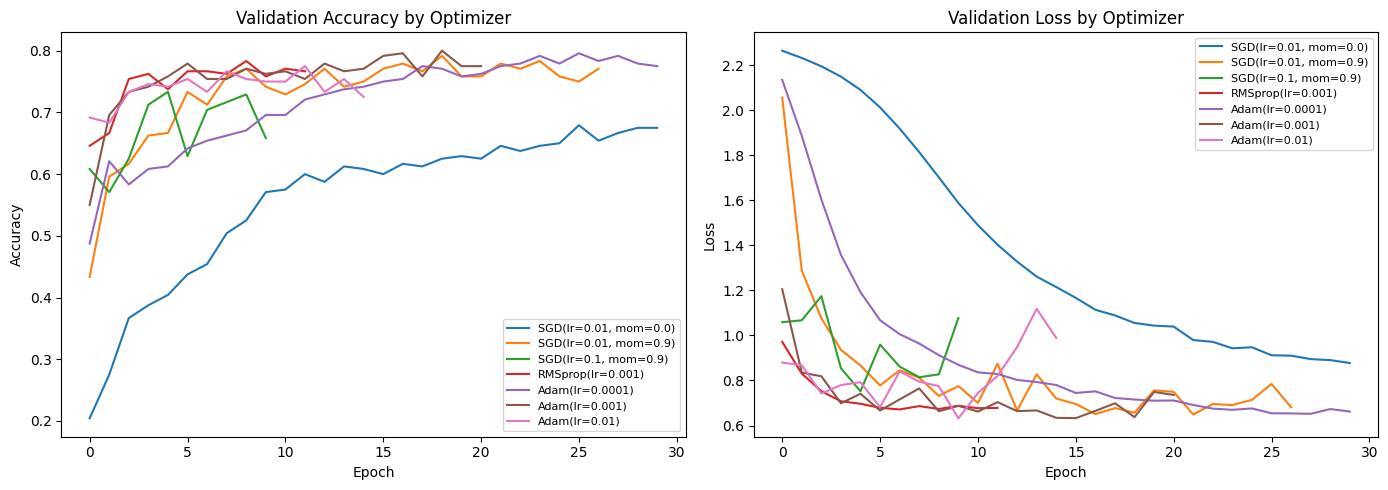

In [50]:
# your code here
# BEGIN SOLUTION

# Collect all results into one dict
all_results = {}
all_results.update(sgd_results)
all_results['RMSprop(lr=0.001)'] = {'history': rmsprop_history, 'val_acc': rmsprop_val_acc}
all_results.update(adam_results)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for label, result in all_results.items():
    h = result['history']
    axs[0].plot(h['val_accuracy'], label=label)
    axs[1].plot(h['val_loss'], label=label)

axs[0].set_title('Validation Accuracy by Optimizer')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(fontsize=8)

axs[1].set_title('Validation Loss by Optimizer')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(fontsize=8)

plt.tight_layout()

# Summary table
print(f"\n{'Optimizer':<30s} {'Best Val Acc':>12s} {'Epochs':>8s}")
print('-' * 52)
for label, result in all_results.items():
    h = result['history']
    best_epoch = np.argmin(h['val_loss'])
    best_acc = h['val_accuracy'][best_epoch]
    n_epochs = len(h['loss'])
    print(f"{label:<30s} {best_acc:>11.4f} {n_epochs:>8d}")
# END SOLUTION

**End of team activity**